<a href="https://colab.research.google.com/github/pnmq1504/V-n-ngu/blob/main/(Log_price)_Phung_Nguyen_Minh_Quan_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Asset Price Simulation

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import random
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# --- BƯỚC 1: Đọc và xử lý dữ liệu ---
df = pd.read_csv('/content/NASDAQ Composite Historical Data.csv')  # dữ liệu giá cổ phiếu
# Loại bỏ dấu phẩy và chuyển thành float
df['Price'] = df['Price'].str.replace(',', '', regex=False).astype(float)

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values(by='Date').reset_index(drop=True)
df['log_price'] = np.log(df['Price'].replace(0, np.nan))  # Tránh log(0)
df['log_return'] = df['log_price'].diff()
df.dropna(subset=['log_price'], inplace=True)
df.set_index('Date', inplace=True)
print(df)


               Price       Open       High        Low     Vol. Change %  \
Date                                                                      
2021-01-04  12698.45  12,958.52  12,958.73  12,543.24    1.27B   -1.47%   
2021-01-05  12818.96  12,665.65  12,828.27  12,665.65    1.21B    0.95%   
2021-01-06  12740.79  12,666.15  12,909.63  12,649.99    1.45B   -0.61%   
2021-01-07  13067.48  12,867.34  13,090.91  12,867.34    1.25B    2.56%   
2021-01-08  13201.98  13,160.22  13,208.09  13,036.55    1.33B    1.03%   
...              ...        ...        ...        ...      ...      ...   
2024-12-24  20031.13  19,818.48  20,031.13  19,813.76  711.22M    1.35%   
2024-12-26  20020.36  19,979.25  20,070.08  19,888.11    1.03B   -0.05%   
2024-12-27  19722.03  19,896.77  19,904.77  19,553.40    1.28B   -1.49%   
2024-12-30  19486.79  19,460.41  19,622.93  19,342.51    1.30B   -1.19%   
2024-12-31  19310.79  19,551.36  19,563.72  19,283.41    1.35B   -0.90%   

            log_price  l

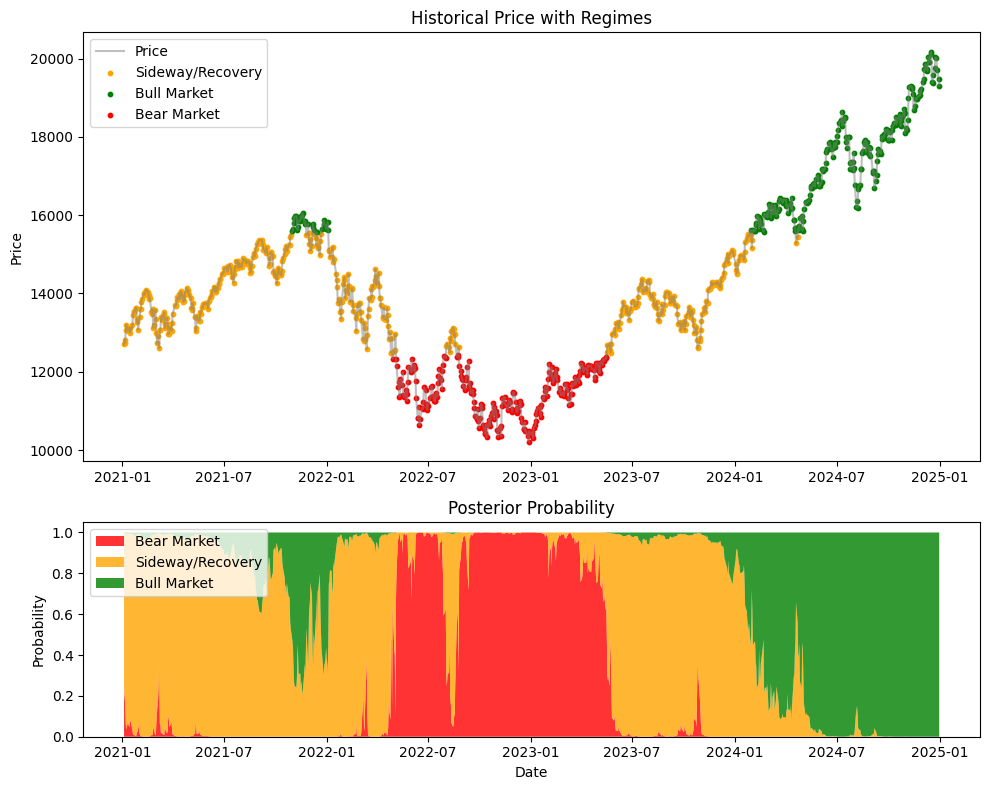

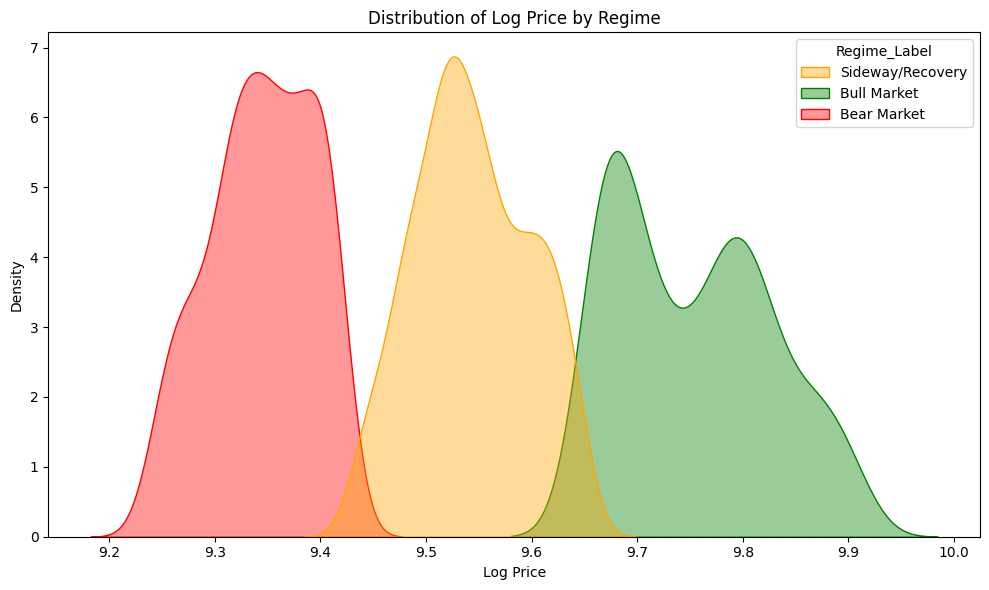

Regime 0 (Bear Market): Mean = 9.3489, Variance = 0.0031, Std Dev = 0.0553 , Weight = 0.2474
Regime 1 (Sideway/Recovery): Mean = 9.5451, Variance = 0.0039, Std Dev = 0.0623 , Weight = 0.4842
Regime 2 (Bull Market): Mean = 9.7417, Variance = 0.0075, Std Dev = 0.0866 , Weight = 0.2685


In [ ]:
# --- BƯỚC 2: Phân chia dự liệu thành từng chế độ (regime)  ---
from matplotlib import gridspec, cm, rcParams, cycler

def classify_regime(series, n_components=3):
    X = series.values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=n_components, n_init=10)
    gmm.fit(X)

    aic = gmm.aic(X)
    bic = gmm.bic(X)
    log_likelihood = gmm.score(X)

    labels = gmm.predict(X)
    probabilities = gmm.predict_proba(X)
    df_result = series.copy().to_frame(name='log_price')
    df_result['Regime'] = labels
    df_result['Date'] = series.index
    df_result.set_index('Date', inplace=True)
    return df_result, gmm, aic, bic, log_likelihood, probabilities

def plot_gmm_results(df, series_name='log_price', price_col='Price', n_components=3):
    df_regime, gmm_model, aic, bic, log_likelihood, probabilities = classify_regime(df[series_name], n_components=n_components)
    df['Regime'] = df_regime['Regime']

    # Sắp xếp và đặt tên regime
    regime_means = gmm_model.means_.flatten()
    sorted_regimes = np.argsort(regime_means)

    true_labels = {
        sorted_regimes[0]: 'Bear Market',
        sorted_regimes[1]: 'Sideway/Recovery',
        sorted_regimes[2]: 'Bull Market'
    }

    label_colors = {
        'Bear Market': 'red',
        'Sideway/Recovery': 'orange',
        'Bull Market': 'green'
    }

    df['Regime_Label'] = df['Regime'].map(true_labels)

    # Cấu hình màu sắc theo chế độ
    regimes_sorted = ['Bear Market', 'Sideway/Recovery', 'Bull Market']
    cmap = cm.get_cmap('RdYlGn_r')
    rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, len(regimes_sorted))))

    # --- VẼ BIỂU ĐỒ GỘP ---
    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[2, 1])
    fig.subplots_adjust(hspace=0.3)

    # Biểu đồ 1: Price theo thời gian
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(df.index, df[price_col], label='Price', color='gray', alpha=0.5)
    for regime_id in sorted(df['Regime'].unique()):
        label = true_labels[regime_id]
        color = label_colors[label]
        ax1.scatter(df[df['Regime'] == regime_id].index,
                    df[df['Regime'] == regime_id][price_col],
                    s=10, label=label, color=color)
    ax1.set_title('Historical Price with Regimes')
    ax1.set_ylabel('Price')
    ax1.legend()

    # Biểu đồ 2: Stackplot của Posterior Probabilities
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    probs_df = pd.DataFrame(probabilities, index=df.index)
    probs_df = probs_df[sorted_regimes]  # sắp theo đúng thứ tự regime
    probs_df.columns = [true_labels[i] for i in sorted_regimes]
    ax2.stackplot(probs_df.index, probs_df.values.T, labels=probs_df.columns, alpha=0.8, colors=[label_colors[lbl] for lbl in probs_df.columns])
    ax2.set_title('Posterior Probability')
    ax2.set_ylabel('Probability')
    ax2.set_xlabel('Date')
    ax2.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    # --- Biểu đồ phân phối log price theo regime ---
    plt.figure(figsize=(10,6))
    sns.kdeplot(
        data=df,
        x=series_name,
        hue='Regime_Label',
        fill=True,
        common_norm=False,
        palette=label_colors,
        alpha=0.4
    )
    plt.title('Distribution of Log Price by Regime')
    plt.xlabel('Log Price')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

    return df, gmm_model, true_labels, sorted_regimes

# --- Gọi hàm ---
df, gmm_model, true_labels, sorted_regimes = plot_gmm_results(df, series_name='log_price', price_col='Price', n_components=3)


# Gán cố định Regime 0 = Bear, 1 = Sideway, 2 = Bull
regime_label_fixed = {
    0: 'Bear Market',
    1: 'Sideway/Recovery',
    2: 'Bull Market'
}
# Đảo ngược mapping: từ regime thật → chỉ số trong GMM ban đầu
reverse_mapping = {v: k for k, v in dict(zip(sorted_regimes, [0, 1, 2])).items()}

# In thông tin theo thứ tự Regime 0-1-2 cố định
for regime_id in [0, 1, 2]:
    label = regime_label_fixed[regime_id]
    gmm_component = sorted_regimes[regime_id]
    mean = gmm_model.means_[gmm_component][0]
    variance = gmm_model.covariances_[gmm_component][0][0]
    std_dev = np.sqrt(variance)
    weight = gmm_model.weights_[gmm_component]
    print(f"Regime {regime_id} ({label}): Mean = {mean:.4f}, Variance = {variance:.4f}, Std Dev = {std_dev:.4f} , Weight = {weight:.4f}")


In [ ]:
# --- BƯỚC 3: Tìm bộ ARIMA cố định để fit ---
from statsmodels.tsa.stattools import adfuller

def find_d(series, max_d=2, alpha=0.05):
    d = 0
    temp_series = series.copy()
    while d <= max_d:
        result = adfuller(temp_series.dropna())
        p_value = result[1]
        if p_value < alpha:
            return d
        temp_series = temp_series.diff()
        d += 1
    return d

from statsmodels.tsa.arima.model import ARIMA

def grid_search_arima(series, d, max_p=3, max_q=3):
    best_aic = float('inf')
    best_order = (0, d, 0)
    for p in range(1, max_p + 1):
        for q in range(1, max_q + 1):
            try:
                model = ARIMA(series, order=(p, d, q))
                result = model.fit()
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, d, q)
            except:
                continue
    return best_order

d = find_d(df['log_price'])  # ADF test trên log(price)
order = grid_search_arima(df['log_price'], d)
print(f"✅ Bộ ARIMA cố định nên dùng: {order}")


✅ Bộ ARIMA cố định nên dùng: (1, 1, 2)


In [ ]:
# --- BƯỚC 4: Fit ARIMA cố định vào từng regime và tính AIC, BIC ---
regime_models = {}
for regime_id in [0, 1, 2]:  # 0, 1, 2
    label = regime_label_fixed[regime_id]
    print(f"\n📊 Fitting FIXED ARIMA{order} for {label} (Regime {regime_id})")

    series = df[df['Regime'] == regime_id]['log_price'].dropna()
    try:
        model = ARIMA(series, order=order)
        result = model.fit()
        print(f"✅ {label} - ARIMA{order} fitted successfully.")
        print(f"AIC: {result.aic:.2f}, BIC: {result.bic:.2f}")
        regime_models[label] = result
    except Exception as e:
        print(f"❌ Error fitting ARIMA for {label}: {e}")
        regime_models[label] = None




📊 Fitting FIXED ARIMA(1, 1, 2) for Bear Market (Regime 0)
✅ Bear Market - ARIMA(1, 1, 2) fitted successfully.
AIC: -2927.05, BIC: -2910.20

📊 Fitting FIXED ARIMA(1, 1, 2) for Sideway/Recovery (Regime 1)
✅ Sideway/Recovery - ARIMA(1, 1, 2) fitted successfully.
AIC: -1594.80, BIC: -1580.58

📊 Fitting FIXED ARIMA(1, 1, 2) for Bull Market (Regime 2)
✅ Bull Market - ARIMA(1, 1, 2) fitted successfully.
AIC: -1280.20, BIC: -1266.19


In [ ]:
# --- Bước 5: Tính lại log-return trong từng regime dựa trên log_price ---
regime_log_returns = {}

# Duyệt qua từng regime
for regime_id in [0, 1, 2]:
    label = regime_label_fixed[regime_id]
    regime_data = df[df['Regime'] == regime_id].copy()
    regime_data['regime_log_return'] = regime_data['log_price'].diff()
    regime_data.dropna(subset=['regime_log_return'], inplace=True)

    # Lưu lại
    regime_log_returns[regime_id] = regime_data['regime_log_return']

    # In số lượng quan sát và hiển thị log-return
    print(f"\n📌 Regime {regime_id} ({label}):")
    print(f"Số lượng quan sát: {len(regime_data)}")
    print(regime_data[['regime_log_return']].head())



📌 Regime 0 (Bear Market):
Số lượng quan sát: 498
            regime_log_return
Date                         
2021-01-05           0.009445
2021-01-06          -0.006117
2021-01-07           0.025318
2021-01-08           0.010240
2021-01-11          -0.012619

📌 Regime 1 (Sideway/Recovery):
Số lượng quan sát: 259
            regime_log_return
Date                         
2021-11-02           0.003436
2021-11-03           0.010297
2021-11-04           0.008109
2021-11-05           0.001960
2021-11-08           0.000674

📌 Regime 2 (Bull Market):
Số lượng quan sát: 245
            regime_log_return
Date                         
2022-05-05          -0.001375
2022-05-06          -0.014147
2022-05-09          -0.043882
2022-05-10           0.009796
2022-05-11          -0.032332


In [ ]:
# Cần check lại
print(f"\n📊 {label} (Regime {regime_id}):")
print(f"- Mean return: {series.mean():.4f}")
print(f"- Volatility (std): {series.std():.4f}")
print(f"- Skewness: {series.skew():.4f}")
print(f"- Kurtosis: {series.kurt():.4f}")


📊 Bull Market (Regime 2):
- Mean return: 9.3446
- Volatility (std): 0.0494
- Skewness: -0.2798
- Kurtosis: -0.8641


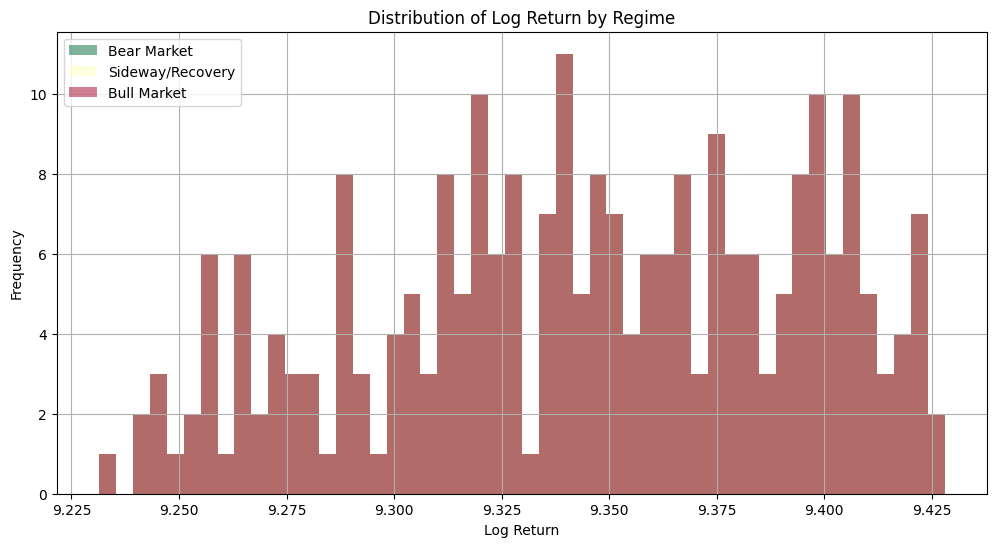

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for regime_id in [0, 1, 2]:
    label = regime_label_fixed[regime_id]
    series_1 = df[df['Regime'] == regime_id]['log_return'].dropna()
    plt.hist(series, bins=50, alpha=0.5, label=f"{label}")

plt.title("Distribution of Log Return by Regime")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pymc as pm
import pytensor.tensor as pt
from pytensor.scan import scan
# Bước 6: Ước lượng phân phối posterior cho các tham số ϕ,𝜃
regime_posteriors = {}

for regime_id in [0, 1, 2]:
    label = regime_label_fixed[regime_id]
    print(f"\n📈 Sampling with Metropolis-Hastings for {label} (Regime {regime_id})")

    # Chuỗi log-price đã phân regime
    series = df[df['Regime'] == regime_id]['log_price'].dropna()


    # Chuẩn hóa
    series_std = (series - series.mean()) / series.std()
    y = series_std.values
    n = len(y)

    with pm.Model() as model:
        # Priors cho tham số ARIMA(1,1,2)
        phi = pm.Normal("phi", mu=0, sigma=1)
        theta1 = pm.Normal("theta1", mu=0, sigma=1)
        theta2 = pm.Normal("theta2", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sigma=1)

        # Chuẩn bị dữ liệu đầu vào cho scan
        y_shared = pt.as_tensor_variable(y)

        # Giả sử y đã là chuỗi chuẩn hóa và đã diff rồi
        y_shift_1 = np.concatenate([[0], y[:-1]])        # y_{t-1}
        eps_shift_1 = np.concatenate([[0], np.zeros(n-1)])  # ε_{t-1}
        eps_shift_2 = np.concatenate([[0, 0], np.zeros(n-2)])  # ε_{t-2}

        # Trước tiên: mu dựa trên y và placeholder epsilon
        mu = phi * y_shift_1 + theta1 * eps_shift_1 + theta2 * eps_shift_2

        # Sau đó: epsilon = y - mu
        eps = y - mu


        # Định nghĩa likelihood (bỏ 2 giá trị đầu tiên)
        pm.Normal("obs", mu=mu[2:], sigma=sigma, observed=y[2:])

        # Sampling
        trace = pm.sample(
            draws=5000,
            tune=5000,
            chains=2,
            step=pm.Metropolis(),
            return_inferencedata=True,
            progressbar=True
        )

        regime_posteriors[regime_id] = trace



📈 Sampling with Metropolis-Hastings for Bear Market (Regime 0)


Output()


📈 Sampling with Metropolis-Hastings for Sideway/Recovery (Regime 1)


Output()


📈 Sampling with Metropolis-Hastings for Bull Market (Regime 2)


Output()

In [ ]:
for regime_id, trace in regime_posteriors.items():
    label = regime_label_fixed[regime_id].replace("/", "_").replace(" ", "_")
    filename = f"posterior_trace_regime_{regime_id}_{label}.nc"
    trace.to_netcdf(filename)
    print(f"💾 Saved posterior for Regime {regime_id} to {filename}")


💾 Saved posterior for Regime 0 to posterior_trace_regime_0_Bear_Market.nc
💾 Saved posterior for Regime 1 to posterior_trace_regime_1_Sideway_Recovery.nc
💾 Saved posterior for Regime 2 to posterior_trace_regime_2_Bull_Market.nc


array([<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'theta1'}>,
       <Axes: title={'center': 'theta2'}>], dtype=object)

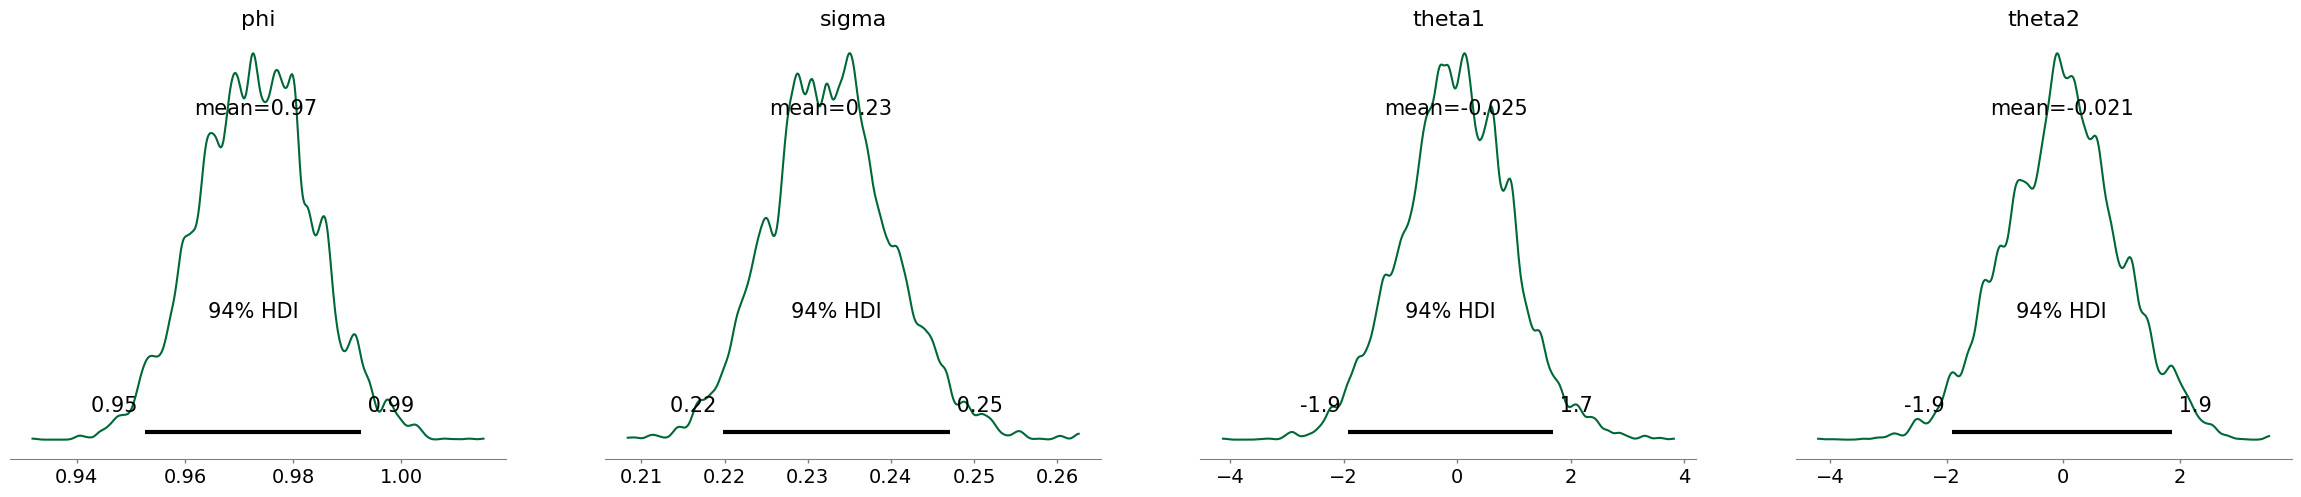

In [ ]:
trace = az.from_netcdf("posterior_trace_regime_0_Bear_Market.nc")
az.plot_posterior(trace)


🎯 Posterior Distribution for Regime 0 (Bear Market)

🎯 Posterior Distribution for Regime 1 (Sideway/Recovery)

🎯 Posterior Distribution for Regime 2 (Bull Market)


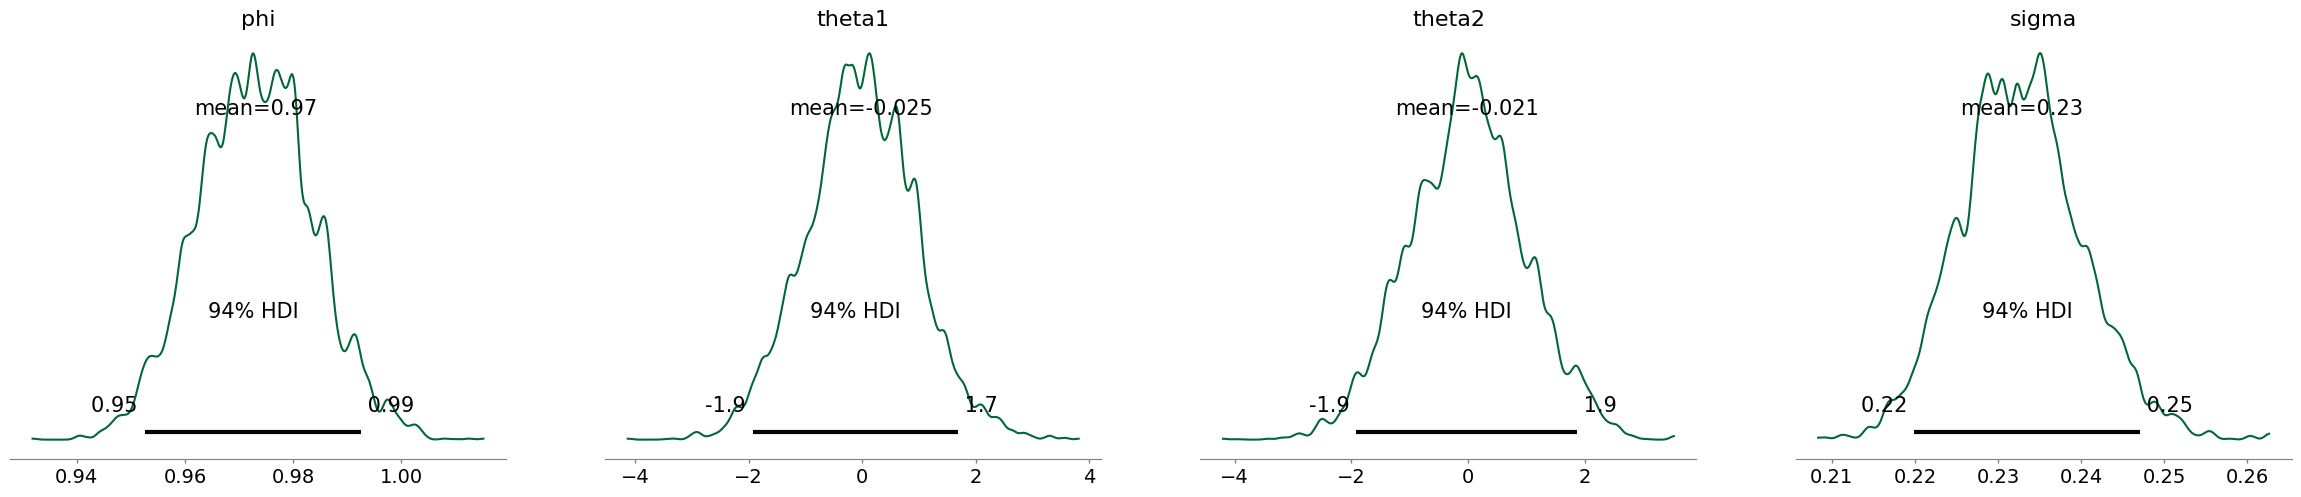

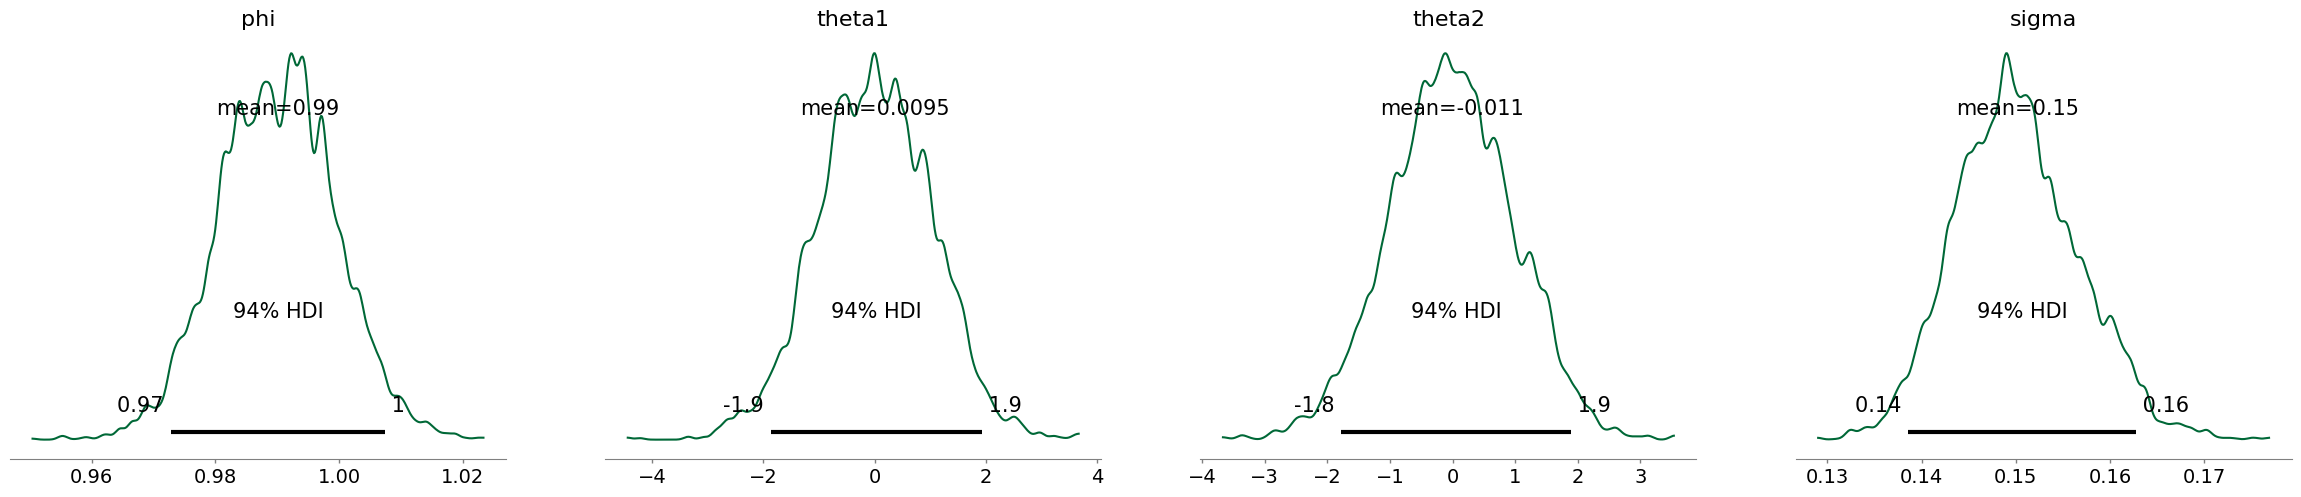

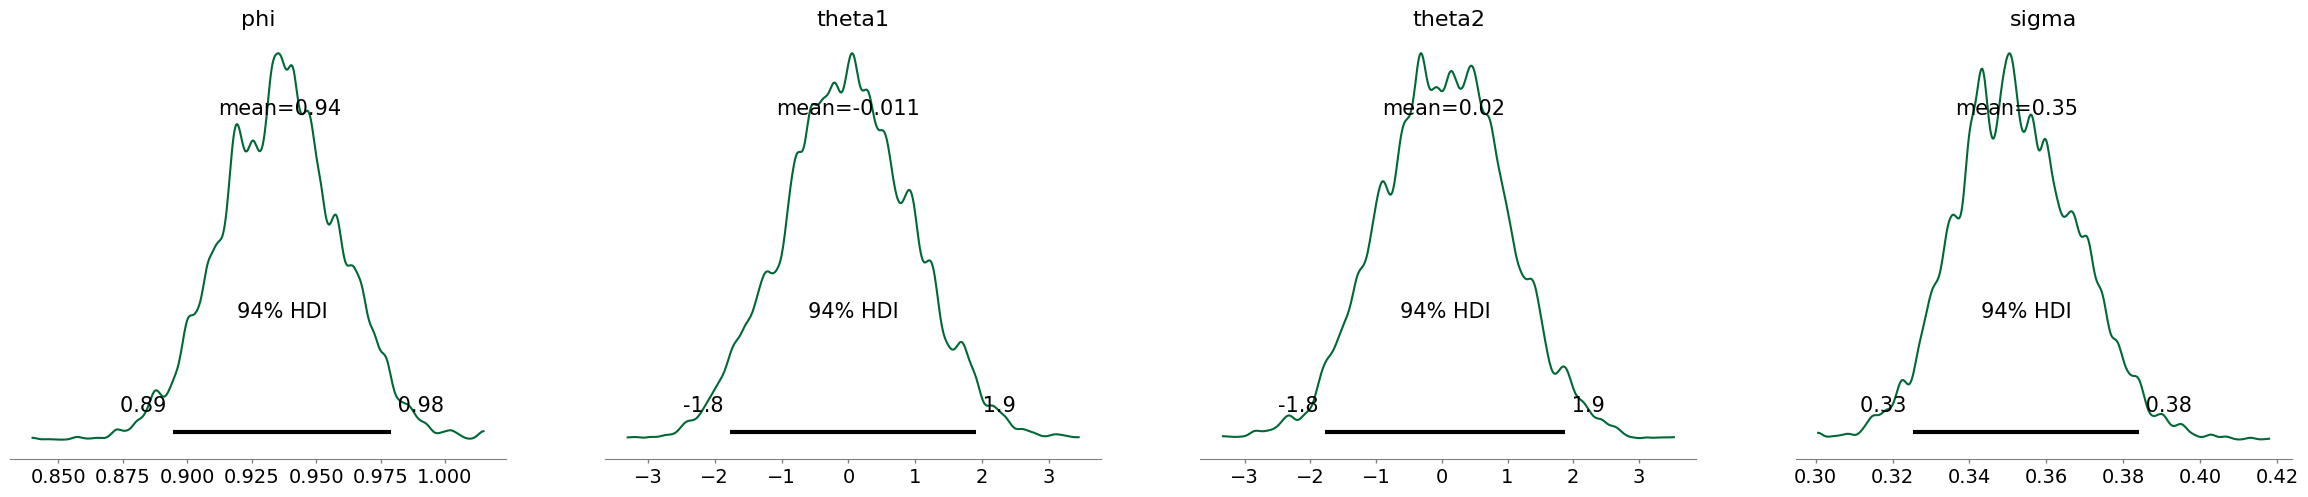

In [ ]:
for regime_id, trace in regime_posteriors.items():
    label = regime_label_fixed[regime_id]
    print(f"\n🎯 Posterior Distribution for Regime {regime_id} ({label})")
    az.plot_posterior(trace, var_names=["phi", "theta1", "theta2", "sigma"])


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

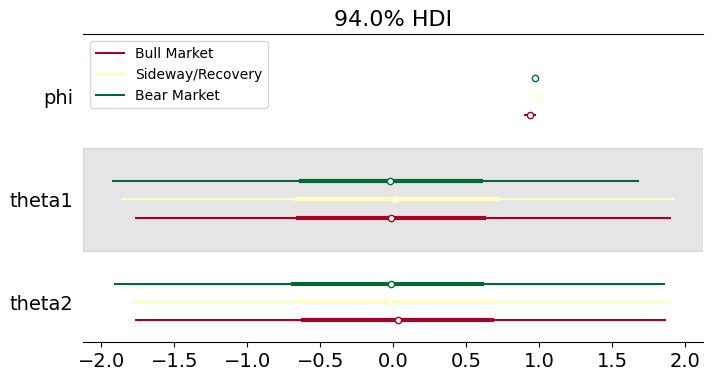

In [ ]:
az.plot_forest(
    list(regime_posteriors.values()),
    model_names=[regime_label_fixed[i] for i in [0, 1, 2]],
    var_names=["phi", "theta1", "theta2"],
    combined=True,
    figsize=(8, 4)
)

In [ ]:
print(az.summary(trace, hdi_prob=0.95))

         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
phi     0.936  0.023     0.890      0.979      0.001    0.000    1555.0   
sigma   0.352  0.016     0.322      0.383      0.000    0.000    1791.0   
theta1 -0.011  0.983    -1.893      1.917      0.022    0.015    2043.0   
theta2  0.020  0.974    -1.810      1.961      0.021    0.015    2076.0   

        ess_tail  r_hat  
phi       2001.0    1.0  
sigma     2085.0    1.0  
theta1    2435.0    1.0  
theta2    2224.0    1.0  


In [ ]:
# Immediately after fitting the model and sampling, check the contents of the trace:
print(trace.posterior.keys())

KeysView(<xarray.Dataset> Size: 360kB
Dimensions:  (chain: 2, draw: 5000)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 40kB 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999
Data variables:
    phi      (chain, draw) float64 80kB 0.924 0.924 0.924 ... 0.961 0.961 0.961
    sigma    (chain, draw) float64 80kB 0.3573 0.3341 0.3341 ... 0.3694 0.3694
    theta1   (chain, draw) float64 80kB 1.487 1.487 1.487 ... 0.7428 0.4364
    theta2   (chain, draw) float64 80kB -0.2401 -0.6879 ... -0.6539 -0.6539
Attributes:
    created_at:                 2025-05-19T17:29:32.373707+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0
    sampling_time:              19.602863788604736
    tuning_steps:               5000)


In [ ]:
print(regime_posteriors.keys())

dict_keys([0, 1, 2])


In [ ]:
for regime_id in [0, 1, 2]:
    if regime_id in regime_posteriors:
        trace = regime_posteriors[regime_id]
        if "phi" in trace.posterior and "theta1" in trace.posterior and "theta2" in trace.posterior:
            print(f"✅ Trace for regime {regime_id} is ready.")
        else:
            print(f"⚠️ Trace for regime {regime_id} is incomplete.")
    else:
        print(f"❌ No trace found for regime {regime_id}.")


✅ Trace for regime 0 is ready.
✅ Trace for regime 1 is ready.
✅ Trace for regime 2 is ready.


In [ ]:
for regime_id, trace in regime_posteriors.items():
    print(f"Regime {regime_id} - Samples: {len(trace.posterior['phi'].values.flatten())}")


Regime 0 - Samples: 10000
Regime 1 - Samples: 10000
Regime 2 - Samples: 10000


In [ ]:
for regime_id in [0, 1, 2]:
    if regime_id in regime_posteriors:
        trace = regime_posteriors[regime_id]
        try:
            phi_vals = trace.posterior['phi']
            theta1_vals = trace.posterior['theta1']
            theta2_vals = trace.posterior['theta2']
            print(f"✅ Regime {regime_id}: All parameters present.")
        except KeyError as e:
            print(f"❌ Regime {regime_id}: Missing parameter {e}")
    else:
        print(f"❌ Regime {regime_id}: No trace found.")


✅ Regime 0: All parameters present.
✅ Regime 1: All parameters present.
✅ Regime 2: All parameters present.


In [ ]:
for regime_id, trace in regime_posteriors.items():
    print(f"\nRegime {regime_id} trace variables:")
    print(list(trace.posterior.data_vars))



Regime 0 trace variables:
['phi', 'sigma', 'theta1', 'theta2']

Regime 1 trace variables:
['phi', 'sigma', 'theta1', 'theta2']

Regime 2 trace variables:
['phi', 'sigma', 'theta1', 'theta2']


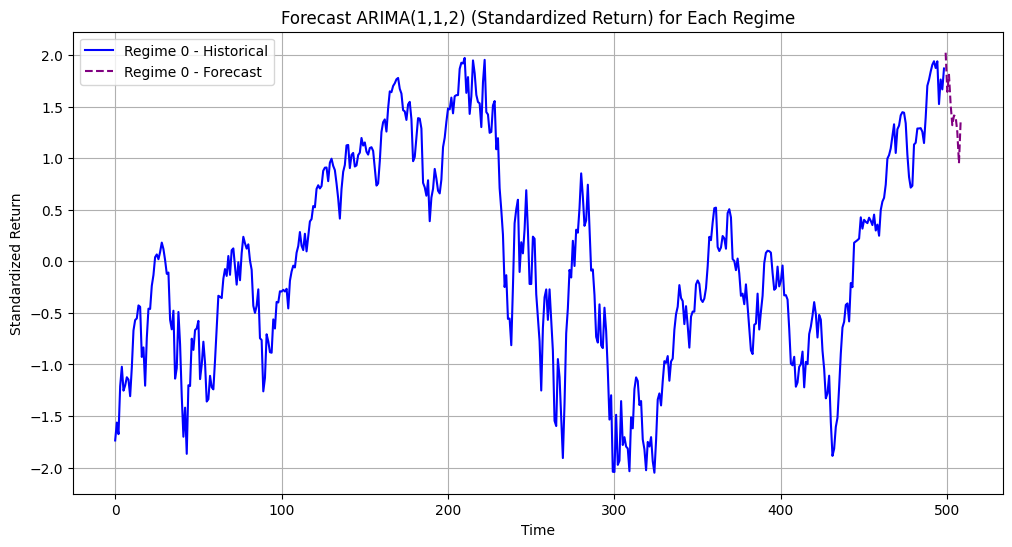

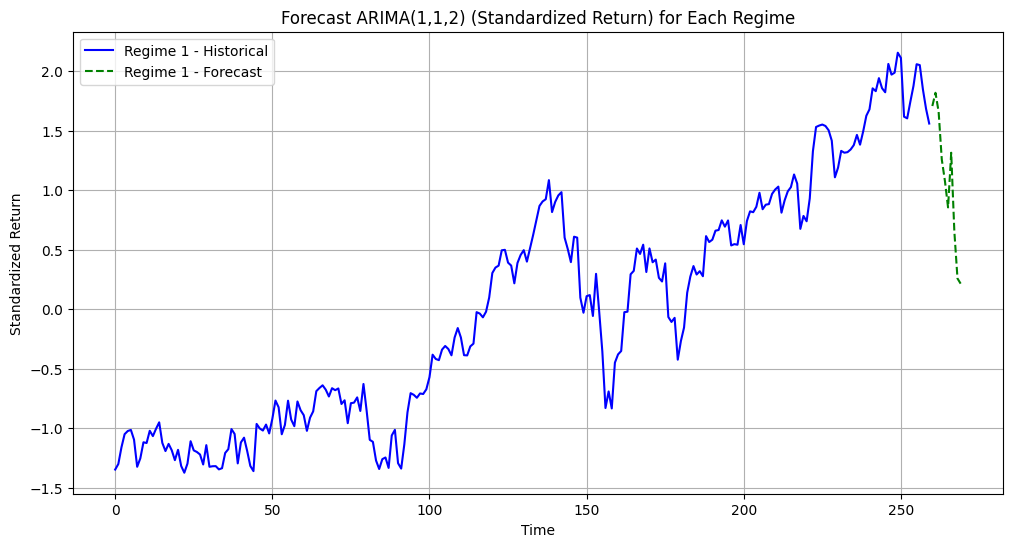

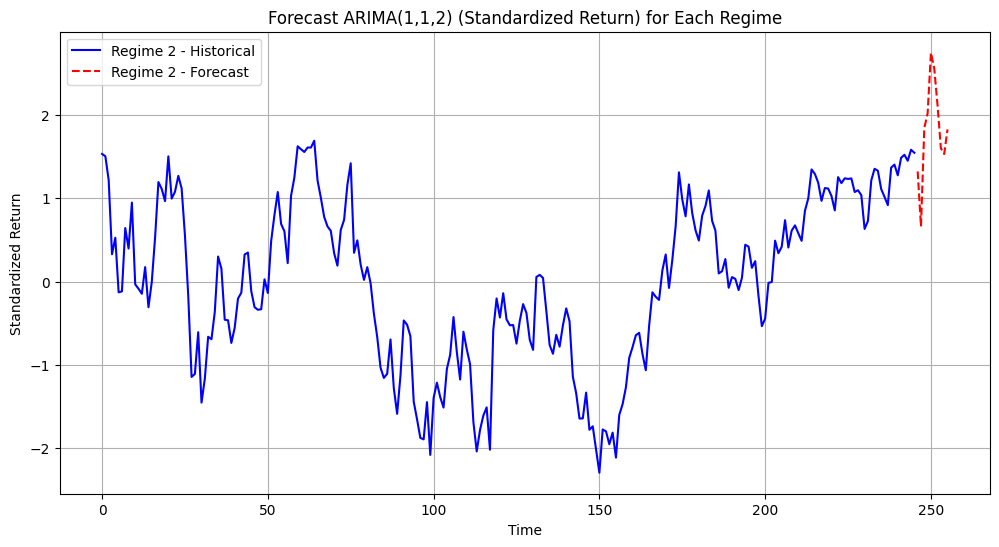

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Bước 7: Dự báo với các tham số posterior đã lấy mẫu cho từng regime
future_steps = 10  # Dự báo 10 bước
forecasted_values = {}

color = ["purple", "green", "red"]
for regime_id in [0, 1, 2]:
    trace = regime_posteriors[regime_id]

    phi_samples = trace.posterior['phi'].values.flatten()
    theta1_samples = trace.posterior['theta1'].values.flatten()
    theta2_samples = trace.posterior['theta2'].values.flatten()
    sigma_samples = trace.posterior['sigma'].values.flatten()

    # Lấy lại chuỗi y cuối cùng cho regime đó (đã chuẩn hóa và differenced)
    series = df[df['Regime'] == regime_id]['log_price'].dropna()

    series_std = (series - series.mean()) / series.std()
    y = series_std.values
    # Khởi tạo mảng forecast
    y_forecast = np.zeros(future_steps)
    eps_forecast = np.zeros(future_steps)

    for i in range(future_steps):
        # Lấy mẫu posterior
        phi = np.random.choice(phi_samples)
        theta1 = np.random.choice(theta1_samples)
        theta2 = np.random.choice(theta2_samples)
        sigma = np.random.choice(sigma_samples)

        # Sinh epsilon ~ N(0, sigma)
        eps_t = np.random.normal(0, sigma)

        # Lấy y_{t-1}
        if i == 0:
            y_prev = y[-1]
            eps_prev1 = 0
            eps_prev2 = 0
        elif i == 1:
            y_prev = y_forecast[i-1]
            eps_prev1 = eps_forecast[i-1]
            eps_prev2 = 0
        else:
            y_prev = y_forecast[i-1]
            eps_prev1 = eps_forecast[i-1]
            eps_prev2 = eps_forecast[i-2]

        # Tính y_t
        y_t = phi * y_prev + theta1 * eps_prev1 + theta2 * eps_prev2 + eps_t

        y_forecast[i] = y_t
        eps_forecast[i] = eps_t

    forecasted_values[regime_id] = y_forecast

    plt.figure(figsize=(12, 6))
    # Vẽ biểu đồ
    plt.plot(range(len(y)), y, label=f'Regime {regime_id} - Historical', c="blue")
    plt.plot(range(len(y), len(y) + future_steps), y_forecast,
             label=f'Regime {regime_id} - Forecast', linestyle='--', c=color[regime_id])

    plt.title("Forecast ARIMA(1,1,2) (Standardized Return) for Each Regime")
    plt.xlabel("Time")
    plt.ylabel("Standardized Return")
    plt.legend()
    plt.grid(True)
    plt.show()


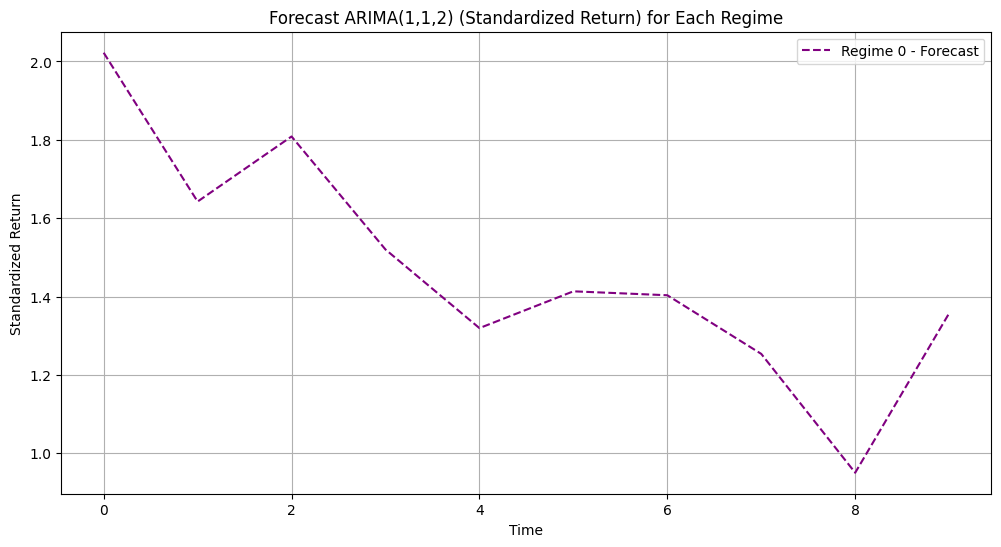

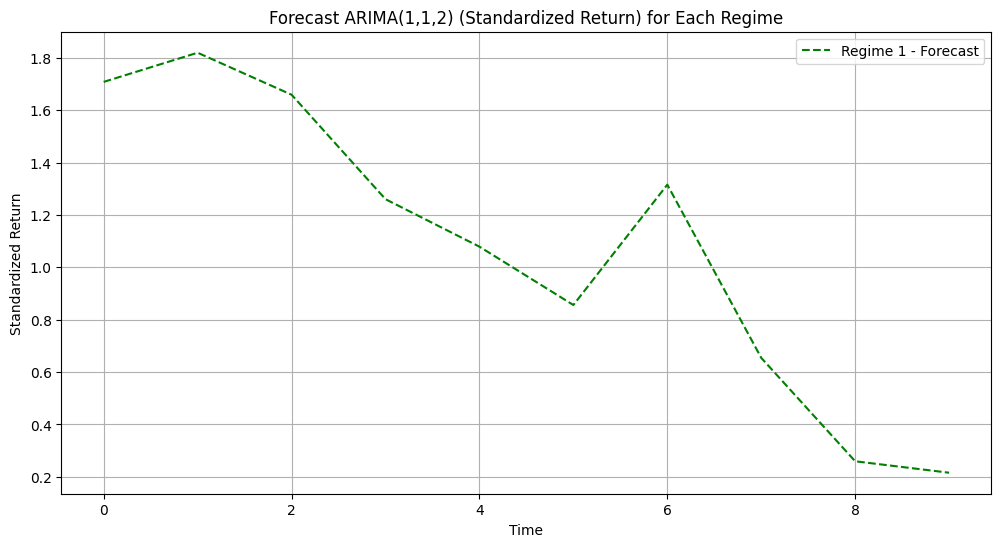

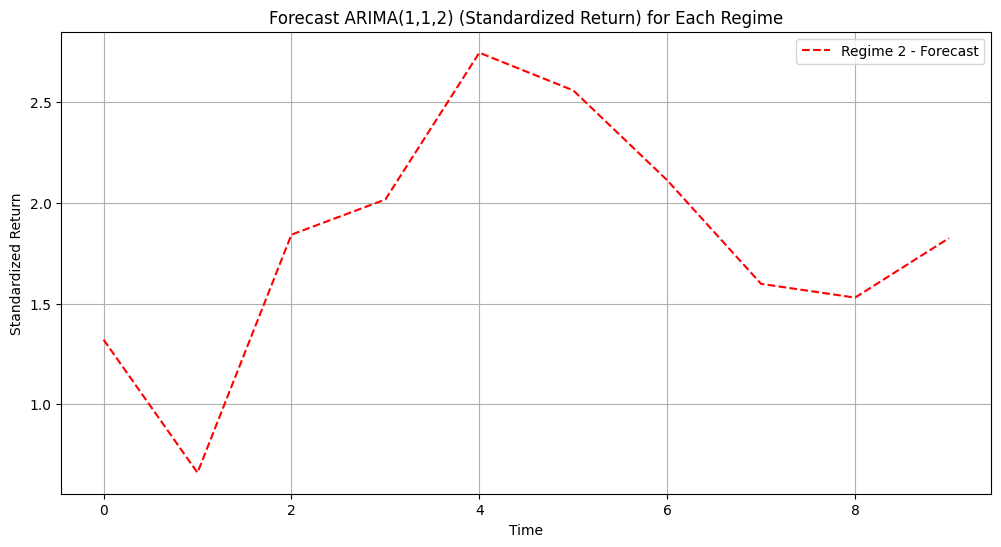

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Bước 7: Dự báo với các tham số posterior đã lấy mẫu cho từng regime
future_steps = 10  # Dự báo 10 bước

color = ["purple", "green", "red"]

for regime_id in [0, 1, 2]:

    y_forecast = forecasted_values[regime_id]

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(range(future_steps), y_forecast, label=f'Regime {regime_id} - Forecast', linestyle='--', c=color[regime_id])

    plt.title("Forecast ARIMA(1,1,2) (Standardized Return) for Each Regime")
    plt.xlabel("Time")
    plt.ylabel("Standardized Return")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Chỉnh code dưới đổi đơn vị !!!!

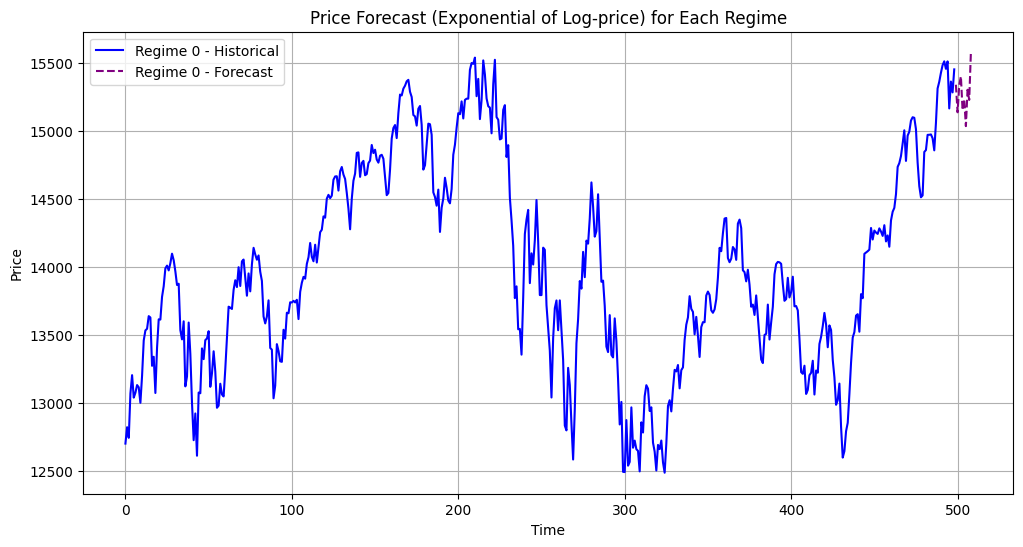

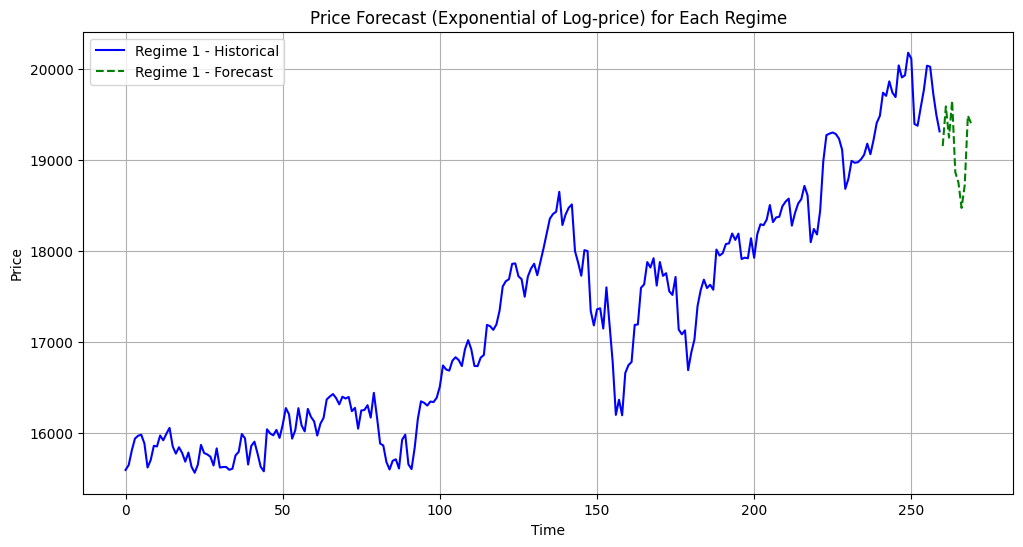

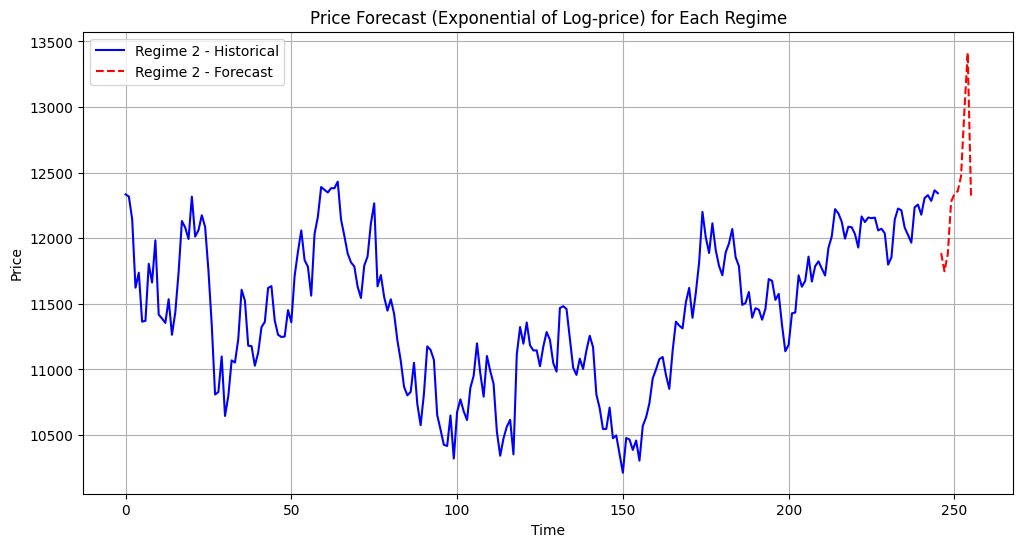

In [ ]:
# Chỉnh sửa
def price_inverse(log_price):
    return np.exp(log_price)

for regime_id in [0, 1, 2]:
    series = df[df['Regime'] == regime_id]['log_price'].dropna()
    y_forecast = price_inverse(log_price = forecasted_values[regime_id] * series.std() + series.mean())

    # Vẽ biểu đồ giá trị thực tế (price) dự báo
    plt.figure(figsize=(12, 6))
    y = np.exp(series).values
    plt.plot(range(len(y)), y, label=f'Regime {regime_id} - Historical', c="blue")
    plt.plot(range(len(y), len(y)+future_steps), y_forecast,
             label=f'Regime {regime_id} - Forecast', linestyle='--', c=color[regime_id] )

    # Vẽ dự báo price
    plt.title("Price Forecast (Exponential of Log-price) for Each Regime")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
price_inverse

<function __main__.price_inverse(log_price)>